# Choosing a location for a well

The client is a mining company. The task is to decide where to drill a new well.

The data is oil samples in three regions: there are 10,000 oilfields in each, where the quality of oil and the volume of its reserves have been measured. The task is to build a machine learning model to help determine the region where mining will bring in the most profit. There is also a task to analyze possible profits and risks using the *Bootstrap* technique

Steps to choose a location are the following:

- In the selected region, they are looking for oilfields, for each, the values of the parameters are determined;
- Build a model and estimate the volume of reserves;
- Select the wells with the highest value estimates. The number of wells depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected wells.

**Task conditions**: 

1) Only linear regression is suitable for training the model (the rest are not predictable enough).

2) During the exploration of the region, 500 wells are explored, from which, using machine learning, the best 200 are selected for development.

3) The budget for the development of wells in the region is 10 billion rubles.

4) One barrel of raw materials brings 450 rubles of income (at current prices). The income from each unit of the product is 450 thousand rubles, since the volume is indicated in thousands of barrels.

5) After assessing the risks, only those regions, where the probability of losses is less than 2.5%, are left. Among them, the region with the highest average profit is chosen.

**Contents**<br/>

<a href='#first'>1) Data preprocessing</a> <br/>
<a href='#second'>2) Train and validate the models</a> <br/>
<a href='#third'>3) Profit calculation preparation</a> <br/>
<a href='#fourth'>4) Profit and risks calculation</a> <br/>
<a href='#fifth'>5) Summary</a>

<a id='first'></a>
## 1. Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

dfs = [df_0, df_1, df_2]
for df in dfs:
    df.info()
    print()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<AxesSubplot:>

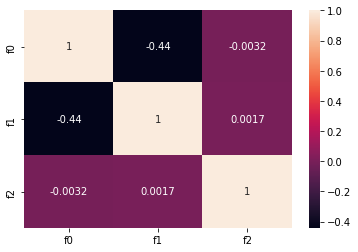

In [3]:
corr_matrix_0 = df_0.drop('product',1).corr()
sn.heatmap(corr_matrix_0, annot=True)

<AxesSubplot:>

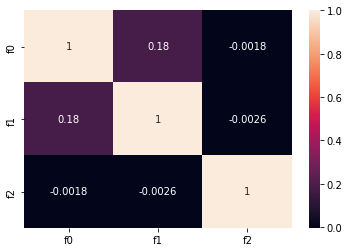

In [4]:
corr_matrix_1 = df_1.drop('product',1).corr()
sn.heatmap(corr_matrix_1, annot=True)

<AxesSubplot:>

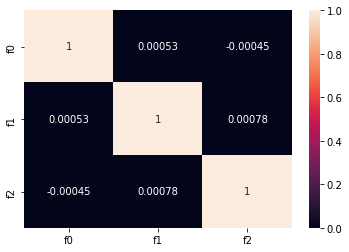

In [5]:
corr_matrix_2 = df_2.drop('product',1).corr()
sn.heatmap(corr_matrix_2, annot=True)

### Conclusion

The dataframes were researched at the first step. Each of them already has correct data types, does not contain missed values. The multocollinearity check was conducted - no high correlation was observed.
The features for learning are `f0`, `f1` and `f2`. The target feature is `product`.

<a id='second'></a>
## 2. Train and validate the models

In [6]:
#function for calculating the average and rmse
def rmse(target, predicted):
    mse = mean_squared_error(target, predicted)
    rmse = mse**(1/2)
    print("Average predicted raw materials stock", predicted.mean())
    print("Model mean square error", rmse)
    print()

In [7]:
#save predictions and targets in separate variables and print rmse and mean value
features_0 = df_0.drop(['id','product'],1)
target_0 = df_0['product']
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=12345)
print("Sample shape:", features_train_0.shape[0], features_valid_0.shape[0])
model = LinearRegression()
model.fit(features_train_0, target_train_0)
predicted_valid_0 = model.predict(features_valid_0)

rmse(target_valid_0, predicted_valid_0)

Sample shape: 75000 25000
Average predicted raw materials stock 92.59256778438035
Model mean square error 37.5794217150813



In [8]:
features_1 = df_1.drop(['id','product'],1)
target_1 = df_1['product']
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=12345)
model = LinearRegression()
model.fit(features_train_1, target_train_1)
predicted_valid_1 = model.predict(features_valid_1)

rmse(target_valid_1, predicted_valid_1)

Average predicted raw materials stock 68.728546895446
Model mean square error 0.893099286775617



In [9]:
features_2 = df_2.drop(['id','product'],1)
target_2 = df_2['product']
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=12345)
model = LinearRegression()
model.fit(features_train_2, target_train_2)
predicted_valid_2 = model.predict(features_valid_2)

rmse(target_valid_2, predicted_valid_2)

Average predicted raw materials stock 94.96504596800489
Model mean square error 40.02970873393434



### Conclusion

A linear regression model was built for each region at the second step.
The model for the second region demonstrated the highest `accuracy` - the root mean square error was only 0.89, while the error for the first and third regions was 37.57 and 40, respectively. The root mean square error in this case shows how much the model is wrong (in thousand barrels). With averages of 93 and 95 thousand barrels, an error of 38 and 40 thousand barrels may indicate that the true values will have a large spread.

<a id='third'></a>
## Profit calculation preparation

In [10]:
barrel_price = 450 # revenue of 1 barrel
costs = 10000000 #10 million, since the number of wells is in thousand, thus, the proceeds will be given in thousand rubles
well_explore = 500 #number of wells for the research
well_develop = 200 #number of wells to develop

#costs = barrel_price*well_develop*product_breakeven - breakeven point formula
product_breakeven = costs/(barrel_price*well_develop) #calculate breakeven point
product_breakeven

111.11111111111111

### Conclusion

Preparatory work for the profit calculation has been done at this step.
In order to reach the break-even point, it is necessary to produce an average of 111 thousand barrels per well. This value exceeds the average reserve of one well, however, since the best wells for development are selected, there is a chance that the development will be able to break even.

<a id='fourth'></a>
## 4. Profit and risks calculation

In [11]:
#breakeven point formula
def profit(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    return (barrel_price*selected.sum() - costs) 

In [12]:
#risk and rewards calculation function using the bootstrap
def bootstrap(target, predictions):
    state = np.random.RandomState(12345)
    values = []
    values_negative = [] 
    target = target.reset_index(drop=True)
    predictions = pd.Series(predictions)
    for i in range(1000):
        target_subsample = target.sample(n=well_explore, replace=True, random_state = state)
        probabilities_subsample = predictions[target_subsample.index]
        profit_oil = profit(target_subsample, probabilities_subsample, well_develop)
        values.append(profit_oil)
        if profit_oil<0:
            values_negative.append(profit_oil)
    
    values = pd.Series(values)
    values_negative = pd.Series(values_negative)
    
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    loss = values_negative.count()/values.count()
    
    print(f"Average profit: {mean:,.0f} thou.rub.")
    print(f"95% confidence interval: {lower:,.0f} thou.rub. : {upper:,.0f} thou.rub.")
    print(f"Loss risk: {loss:.1%}")
    sn.distplot(values)

Average profit: 425,939 thou.rub.
95% confidence interval: -102,090 thou.rub. : 947,976 thou.rub.
Loss risk: 6.0%


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


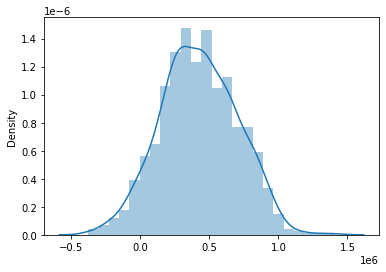

In [13]:
#risk and profits calculation region wise
bootstrap(target_valid_0, predicted_valid_0)

Average profit: 515,223 thou.rub.
95% confidence interval: 68,873 thou.rub. : 931,548 thou.rub.
Loss risk: 1.0%


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


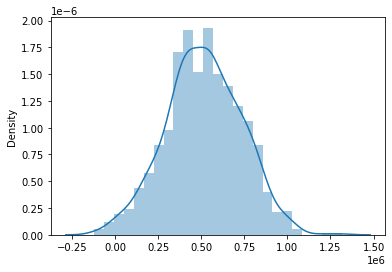

In [14]:
#risk and profits calculation region wise
bootstrap(target_valid_1, predicted_valid_1)

Average profit: 435,008 thou.rub.
95% confidence interval: -128,881 thou.rub. : 969,707 thou.rub.
Loss risk: 6.4%


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


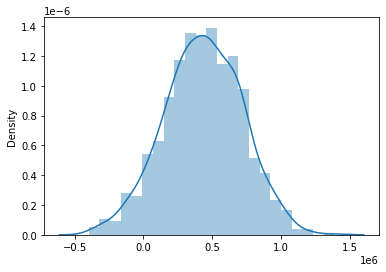

In [15]:
#risk and profits calculation region wise
bootstrap(target_valid_2, predicted_valid_2)

### Conclusion

The last step was dedicated to the profit calculation using the *Bootstrap* technique: calculation of the average profit, 95% interval and the risk of a loss for each region. Profit distribution graphs were also displayed, the distribution in all regions corresponds to the normal.

The second region has shown the highest figures - on average, profit is 515 million rubles, against 426 and 435 million rubles in other regions, the risk of loss is 1% versus 6% and 6.4% in the other two regions, the 95% confidence interval includes positive values. The graph shows that the minimum value in the second region is also lower (-250 million rubles, against - 500 million rubles in other regions).

<a id='fifth'></a>
## 5. Summary

Based on the data obtained after the *Bootsrtap* technique application, the **second region** is the most attractive region for the well development. With 95% certainty, it can be argued that the break-even point will be reached. At the same time, the region showed the highest rate of profitability on average, as well as the lowest risk of losses. It was also the only region where the probability of loss is less than 2.5%, which is in line with the target of the task.